# Analysis of CO2 and O2 data

#### Questions:
- How do CO2 and O2 vary across the site?
- How do they relate to each other, and what processes might be producing or consuming these gases?
- How do our spot measurements compare to longer CO2 records?

### Post-processing the CO2 data, and estimating the true pCO2

In [ ]:
from pandas import read_csv
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# The Example CO2 data are in a csv file in the data folder. 

# There is one header row in the csv we need to skip => skiprows=1

# The timestamps are in the second column. We want these as our
# index, for index_col=1 (1 is the second column, 0 would be first).

# We use parse_dates=True, because our index contains timestamps. 

df = read_csv('data/CO2-spot_Savoy.csv',
              skiprows=1,
              parse_dates=True,
              index_col=1
             )

In [ ]:
# Let's print it out to see how it looks.
df

In [ ]:
CO2 = df['ppm, units (LGR S/N: 20253808)'] #Let's just pull out CO2, and give it a sensible name.
CO2.plot()
plt.ylabel('pCO2 (ppm)')

#### This is an example of CO2 data collected in the field. Each of the asymmetric peaks is an equilibration curve, during a period when the CO2 meter is submerged and equilibrating to the pCO2 in the water. Note that neither of these peaks has flattened out into a plateau, so we didn't leave it in long enough to get complete equilibration. 

#### We will zoom in on the first peak to try to approximate the equilibrium value

In [ ]:
# Here we can use date time slicing, where we enter dates and times as strings
start = '2023-05-02 12:20' # Beginning of slice
end = '2023-05-02 12:57' #End of slice
CO2[start:end].plot()
plt.ylabel('pCO2 (ppm)')

#### These peaks are normally an exponential shape, a functional form that is also predicted by theory. Therefore, to estimate the equilibrium form, we will fit an exponential function to this measurement curve.

In [ ]:
# We can define a separate dataframe, CO2_meas that just has this one measurement peak in it
CO2_meas = CO2[start:end]

In [ ]:
# To fit a curve, we want to calculate the seconds from the start of the measurement, 
# rather than time stamps, which are currently on the x axis.
# We can calculate the time since start like this, by subtracting out the initial time.
time_from_start = CO2_meas.index - CO2_meas.index[0] 
#Then, this can be converted into total seconds like this
secs_from_start = time_from_start.total_seconds()

In [ ]:
# Let's plot again with seconds to make sure we got this right.
plt.plot(secs_from_start,CO2_meas)
plt.xlabel('Seconds from start of measurement')
plt.ylabel('CO2  (ppm)')

#### Looks good!

#### We will fit an exponential of the form 

$$\Large{ y(t) = A\left[1-e^{(-t/B)}\right] + C },$$

#### where $A$, $B$, and $C$ are fitting constants.
#### At $t=0$ we have $y(0)=C$, as $t\rightarrow \infty$, the exponential approches zero and we get $y \rightarrow A+C$. Therefore $A+C$ is our equilibrium value. This is what we were trying to measure in the field.

In [ ]:
#Here we define our exponential curve for fitting
def exp_curve(t, A, B, C):
    y = A*(1 - np.exp(-t/B)) + C
    return y

In [ ]:
# import the curve fitting function
from scipy.optimize import curve_fit

#### For curve_fit we provide an initial guess of A, B, and C. If we don't do this, it likely won't find the best solution. Remember, $C$ is what we get at time zero, which here looks about like 1000 ppm. We might plateau somewhere around 6000 ppm, so $A+C\approx 6000$ ppm. Therefore, 5000 ppm seems like a good guess for A. $B$ is a timescale over which the solution changes by a factor of $e$, which is roughly three. Therefore, at $t=B$ the solution should be about 1/3 of the way between the starting point and plateau. 500 secs looks pretty good to me. This is the reasoning that leads to the guesses I use below.

In [ ]:
p_guess = [6000,500,1000]
p_opt, p_cov = curve_fit(exp_curve, secs_from_start, CO2_meas, p_guess) 
# The best fitting parameters are stored in p_opt, in the order in which they are called in the function above, A, B, C.
A_best = p_opt[0]
B_best = p_opt[1]
C_best = p_opt[2]

In [ ]:
# We can calculate the CO2 values from out best fitting exponential by using our defined function,
# and the best-fitting parameters.
co2_fit = exp_curve(secs_from_start, A_best, B_best, C_best)

# Plot the data
plt.plot(secs_from_start,CO2_meas)
# Plot the exponenial curve as a dashed line.
plt.plot(secs_from_start, co2_fit, '--')
plt.xlabel('Seconds from start of measurement')
plt.ylabel('CO2  (ppm)')
plt.legend(['Data', 'Fit']);


# To illustrate the problem with a poor guess (or no guess, try deleting
# p_guess from the curve_fit function call above and rerun that cell, and 
# this one. What happens to the fit?

In [ ]:
print('A_best =',A_best)
print('B_best =',B_best)
print('C_best =',C_best)

print('Final CO2 =', A_best + C_best)

#### It's not perfect, but this gives us a way of estimating what the CO2 would have been if we had fully equilibrated the sensor. In this case, around 5200 ppm.

#### Now that we have figured out how to do this fit, we can make it easier to do this with other data, if we define some functions that handle the repetitive parts. 

In [ ]:
# Note, for these functions I create what are called doc strings. These will show up as a
# kind of automatic documentation when I try to use the function.

from scipy.optimize import curve_fit

def plot_CO2_measurement(start, end):
    """
    Function to plot a CO2 measurement over specified time range
    
    Parameters
    ----------
    
    start : string
        String containing timestamp of start of measurement
    
    end : string
        String containing timestamp of end of measurement
        
    Returns
    -------
    
    CO2_meas : Series
        Time series of CO2 with seconds from start as the index.
    
    """
    # We can define a separate dataframe that just has this one peak in it
    CO2_meas = CO2[start:end]
    # To fit a curve, we want to calculate the seconds from the start of the measurement, rather than time stamps
    # We can calculate the time since start like this, by subtracting out the initial time.
    time_from_start = CO2_meas.index - CO2_meas.index[0] 
    #Then, this can be converted into total seconds like this
    secs_from_start = time_from_start.total_seconds()
    #Let's reset the index to secs_from_start
    CO2_meas.index = secs_from_start
    # Let's plot again with seconds to make sure we got this right.
    plt.plot(CO2_meas.index,CO2_meas)
    plt.xlabel('Seconds from start of measurement')
    plt.ylabel('CO2  (ppm)')
    return CO2_meas # Return the modified data with CO2 and secs from start



def fit_CO2_measurement(CO2_meas, A_guess, B_guess, C_guess):
    """
    Function to fit and exponential curve to a CO2 measurement
    
    Parameters
    ----------
    
    CO2_meas : Series
        A Series object containing CO2 values and an index equal to seconds from the start.
    
    A_guess : float
        Initial guess of A in exponential fit.
        
    B_guess : float
        Initial guess of B in exponential fit.
        
    C_guess : float
        Initial guess of C in exponential fit.
        
    Returns
    -------
    
    CO2_final : float
        Estimated equilibrium value of CO2.
    """
    
    #Here we define our exponential curve for fitting
    def exp_curve(t, A,B,C):
        y = A*(1 - np.exp(-t/B)) + C
        return y

    # Fit the exponential
    p_guess = [A_guess,B_guess,C_guess]
    p_opt, p_cov = curve_fit(exp_curve, CO2_meas.index, CO2_meas, p_guess) 
    
    # The best fitting parameters are stored in p_opt, in the order in which they are called in the function above, A, B, C.
    A_best = p_opt[0]
    B_best = p_opt[1]
    C_best = p_opt[2]
    
    co2_fit = exp_curve(CO2_meas.index, A_best, B_best, C_best)

    # Plot the data
    plt.plot(CO2_meas.index,CO2_meas)
    # Plot the exponenial curve as a dashed line.
    plt.plot(CO2_meas.index, co2_fit, '--')
    plt.xlabel('Seconds from start of measurement')
    plt.ylabel('CO2  (ppm)')
    plt.legend(['Data', 'Fit']);
    print("Estimated equilibrium CO2 value is", A_best + C_best)
    return (A_best + C_best)

#### Now we'll use our new function to grab the second big peak in the data.

In [ ]:
start = '2023-05-02 13:54' # Beginning of slice
end = '2023-05-02 14:45' #End of slice

CO2_meas = plot_CO2_measurement(start, end) 
# Try putting your cursor anywhere inside this () and hit shift-Tab. It should pop up our
# docstrings from above. 


In [ ]:
# By visual examination of this curve, we'll guess A=1000, C=10000, B=500

CO2_est = fit_CO2_measurement(CO2_meas, 10000, 500, 1000)

## Boom! 
#### Doesn't that look nice. 

#### Now use these functions to estimate measurement values from your field observations.

In [ ]:
# First, read in the raw data using read_csv

# Plot the whole time series



In [ ]:
# Now use plot_CO2_measurement to zoom in on a specific measurement peak. 


In [42]:
# Now fit the function using CO2_meas returned from the function above and your own guesses of A, B, and C.



### Relationship between CO2 and O2

Now that you have CO2 values, try plotting CO2 vs O2 for all of the sites. This can help us to understand what processes are going on in the Critical Zone (see figure below).

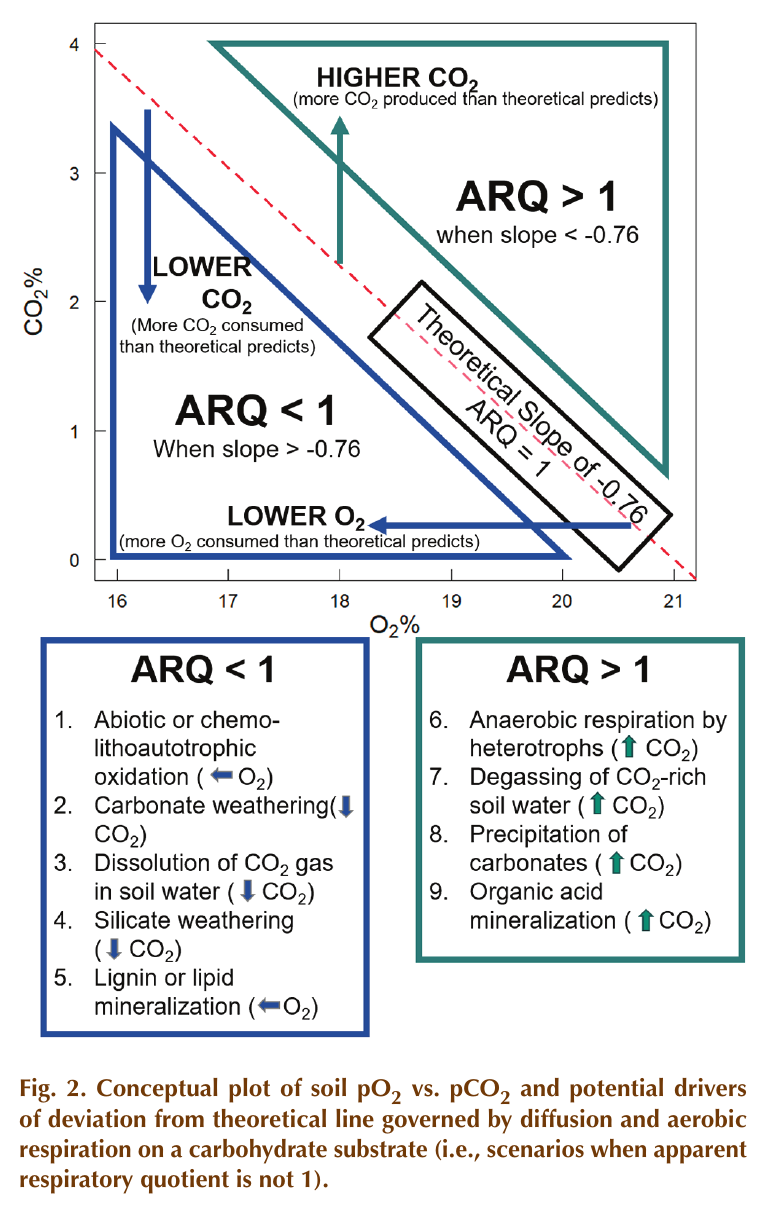

In [53]:
from IPython.display import Image, display
display(Image(filename='figs/ARQ.png'))
# figure is from Hodges et al, 2019, Soil CO2 and O2 
# Concentrations Illuminate the Relative Importance 
# of Weathering and Respiration to Seasonal Soil Gas 
# Fluctuations, Pedology, 83, 1167-1180.

#### We want to make a plot like the one above. To do this, we need to convert our CO2 ppm values into CO2 %.

$$ {\rm CO_2}\% = \frac{{\rm CO_2 ppm}}{ 10000} $$

The theoretical relationship between O2 and CO2 that is produced by respiration is given by,

$$ {\rm CO_2} = -0.76 \times {\rm O_2} + 16$$

and is shown on the plot above.

Text(0, 0.5, '${\\rm CO_2}$%')

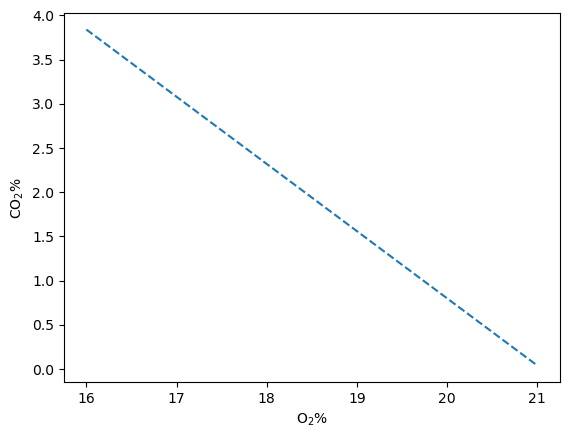

In [60]:
# The theoretical relationship for respiration

O2_resp = np.linspace(16,21, 5)
CO2_resp = -0.76 * O2_resp + 16

plt.plot(O2_resp, CO2_resp, '--')
plt.xlabel(r'${\rm O_2}$%')
plt.ylabel(r'${\rm CO_2}$%')

# Plot your observed CO2 and O2 pairs on top of this relationship and think about processes that
# might result in the observed values.

# Consider making different types of sites different colors (epikarst springs, wells, streams, springs)

## Long-term CO2 records

<AxesSubplot:>

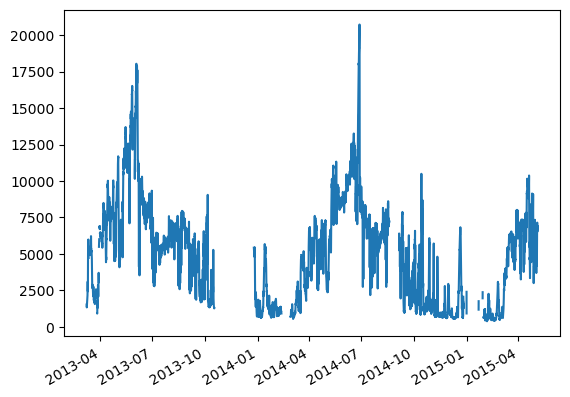

In [49]:
# There are long-term CO2 records from Langle
# and Copperhead Springs in 'data/Langle.csv' and
# 'data/Copperhead.csv' 

# Read in these data and plot up the time series of
# dissolved CO2 at Langle and Copperhead. You can use
# these longer records to get a bigger context for the
# CO2 data you collected yesterday.

